# Time-sharing model

In [240]:
include("simu_utils.jl")
using Distributions    # to draw from uniform
using JLD2    # for data sl
gr()    # should I used this instead of gr()?

Plots.GRBackend()

## Model definition

In [295]:
# duo_input_hill(X, Y, S, D, n) = 
#     (S * X)^n / ((S * X)^n + (D * Y)^n + 1)

function duo_ts_system(; _δ = 1)
    # model definition
    sigma_model = @reaction_network begin
        # sigma factor 1
        1/τ₁ * β₁ * v₀, ∅ --> σ₁
        1/τ₁ * β₁ * duo_input_hill(Rσ₁, A₁, KS₁, KD₁, n₁), ∅ --> σ₁
        1/τ₁, σ₁ --> ∅
        #1/τ₂ * Rσ₁, ∅ --> A₁
        1/τ₂ * β₁ * v₀, ∅ --> A₁
        1/τ₂ * β₁ * duo_input_hill(Rσ₁, A₁, KS₁, KD₁, n₁), ∅ --> A₁
        1/τ₂, A₁ --> ∅
        # sigma factor 2
        1/τ₁ * β₂ * v₀, ∅ --> σ₂
        1/τ₁ * β₂ * duo_input_hill(Rσ₂, A₂, KS₂, KD₂, n₂), ∅ --> σ₂
        1/τ₁, σ₂ --> ∅
        #1/τ₂ * Rσ₂, ∅ --> A₂
        1/τ₂ * β₂ * v₀, ∅ --> A₂
        1/τ₂ * β₂ * duo_input_hill(Rσ₂, A₂, KS₂, KD₂, n₂), ∅ --> A₂
        1/τ₂, A₂ --> ∅
        # sharing of RNAP
        k₁₁, R + σ₁ --> Rσ₁
        k₂₁, Rσ₁ --> R + σ₁
        k₁₂, R + σ₂ --> Rσ₂
        k₂₂, Rσ₂ --> R + σ₂
        
    end v₀ β₁ β₂ KS₁ KD₁ KS₂ KD₂ n₁ n₂ τ₁ τ₂ k₁₁ k₂₁ k₁₂ k₂₂ η    # η is for SDE only
    
    # currently δ is ignored
    # if δ is specified, change the step size
#     if(_δ > 1)
#         # modify the stoich of σ prod
#         @parameters t β S D n τ₁
#         @variables σ(t) A(t)
#         ## the A prod eqn
#         sigma_model.eqs[2] = 
#             Reaction(1/τ₁ * β * duo_input_hill(σ, A, S, D, n), nothing, [σ], nothing, [_δ])
#         println("burst size δ = ", _δ)
#     end
    
    return sigma_model
end

duo_ts_system (generic function with 1 method)

## Simulation

### Utility functions

In [278]:
"""
Similar to simu_all() function, but for duo-time-sharing system
TODO: can merge with simu_all()
"""
function simu_duo_ts_all(_m; _Rₜ = 50, _v₀ = 0.01, _β₁ = 100., _β₂ = 100.,
        _KS₁ = 0.2, _rK₁ = 1., _KS₂ = 0.2, _rK₂ = 1.,
        _n₁ = 3., _n₂ = 3., _τ₁ = 10., _rτ = 1., 
        _k₁₁ = 1e-3, _k₂₁ = 1e-2, _k₁₂ = 1e-3, _k₂₂ = 1e-2, _η = .1, 
        max_t = 2000., stress_t = 500., plot_max_t = 2000., saveat = 1.0,
        method = "ssa", show_tc = true, show_pp = true, show_hill = true,
        quiet = false)
    # k₁₁ is the *association* rate of σ₁ and k₂₁ is the *dissociation* rate of σ_2
    # similarly we have k₁₂ and k₂₂
    # default time of the induction of stress is increased
    # to set Rσ and σ to steady state
    
    tspan = (0., max_t)    # time course
    # initial state, σ₁, A₁, σ₂, A₂, R, Rσ₁, Rσ₂
    u₀ = [0, 0, 0, 0, _Rₜ, 0, 0]

    # parameters, v₀, β, S, D, n, τ₁, τ₂, k₁, k₂, η
    # S is initially set to 0 and subject to a step change
    p = [_v₀, _β₁, _β₂, _KS₁, _rK₁ * _KS₁, _KS₂, _rK₂ * _KS₂, _n₁, _n₂, _τ₁, _τ₁ * _rτ, 
        _k₁₁, _k₂₁, _k₁₂, _k₂₂, _η]
    
    # choose different methods
    if method == "ssa"
        sol = simu_ssa(_m, tspan, u₀, p, stress_t, _saveat = saveat)
    elseif method == "ode"
        sol = simu_ode(_m, tspan, u₀, p, stress_t, _saveat = saveat)
    elseif method == "sde"
        sol = simu_sde(_m, tspan, u₀, p, stress_t, _saveat = saveat)
    else
        println("Simulation method $method not found. Abort.")
        return nothing
    end
    
    # print parameters
    if !quiet
        println("KD₁/KS₁ = ", _rK₁, "; KS₁ = ", _KS₁, 
            "; KD₂/KS₂ = ", _rK₂, "; KS₂ = ", _KS₂, "; τ₂/τ₁ = ", _rτ,
            "; β₁ = ", _β₁, "; β₂ = ", _β₂, "; n₁ = ", _n₁, "; n₂ = ", _n₂, 
            "; k₁₁ = ", _k₁₁, "; k₂₁ = ", _k₂₁, "; k₁₂ = ", _k₁₂, "; k₂₂ = ", _k₂₂,
            "; Rₜ = ", _Rₜ)
    end
    
    # plot
    if !quiet
        if show_tc
            display(plot_timecourse(select_species(sol, [6, 2]), 
                    stress_t, max_t = plot_max_t, labels = ["Rσ₁(t)", "A₁(t)"]))    # σ₁ and A₁
            display(plot_timecourse(select_species(sol, [8, 2]), 
                    stress_t, max_t = plot_max_t, labels = ["σ₁ total", "A₁(t)"]))
            display(plot_timecourse(select_species(sol, [1, 6]), 
                    stress_t, max_t = plot_max_t, labels = ["σ₁ free", "Rσ₁"]))
            display(plot_timecourse(select_species(sol, [6, 7]), 
                    stress_t, max_t = plot_max_t, labels = ["Rσ₁(t)", "Rσ₂(t)"]))    # σ₁ and σ₂
            display(plot_timecourse(select_species(sol, [8, 9]), 
                    stress_t, max_t = plot_max_t, labels = ["σ₁ total", "σ₂ total"]))
            display(plot_timecourse(select_species(sol, [5, 10]), 
                    stress_t, max_t = plot_max_t, labels = ["R free", "R total"]))
        end
        if show_pp
            display(plot_phase_plane(select_species(sol, [6, 2])))    # σ₁ and A₁
            display(plot_phase_plane(select_species(sol, [6, 7])))    # σ₁ and σ₂
        end
        if show_hill
            display(plot_hill(select_species(sol, [1, 2]), 
                    1 / _KS, 1 / (_rK * _KS), _n))
        end
    end
    
    # return arrays
    return sol
end

simu_duo_ts_all

In [5]:
module My
    struct My_solution
        u::Array{Vector{Float64}, 1}
        t::Array{Float64, 1}
    end
end

"""
Select some of the species
1. σ₁, 2. A₁, 3. σ₂, 4. A₂, 5. R, 6. Rσ₁, 7. Rσ₂
8. σ₁ + Rσ₁, 9. σ₂ + Rσ₂, 10. R + Rσ₁ + Rσ₂
"""
function select_species(sol, vals)
    u_ext = [ [sol.u[i]; sol.u[i][1] + sol.u[i][6]; sol.u[i][3] + sol.u[i][7];
        sol.u[i][5] + sol.u[i][6] + sol.u[i][7]] for i = 1:length(sol.u) ]
    new_u = [ u_ext[i][vals] for i = 1:length(u_ext) ]
#     println(typeof(new_u[1]))
    new_sol = My.My_solution(new_u, sol.t)
    return new_sol
end

select_species

### The actual simulation

KD₁/KS₁ = 4.0; KS₁ = 0.25; KD₂/KS₂ = 0.0; KS₂ = 0.25; τ₂/τ₁ = 5.0; β₁ = 50.0; β₂ = 50.0; n₁ = 1.0; n₂ = 1.0; k₁₁ = 0.0005; k₂₁ = 0.05; k₁₂ = 0.0005; k₂₂ = 0.05; Rₜ = 20


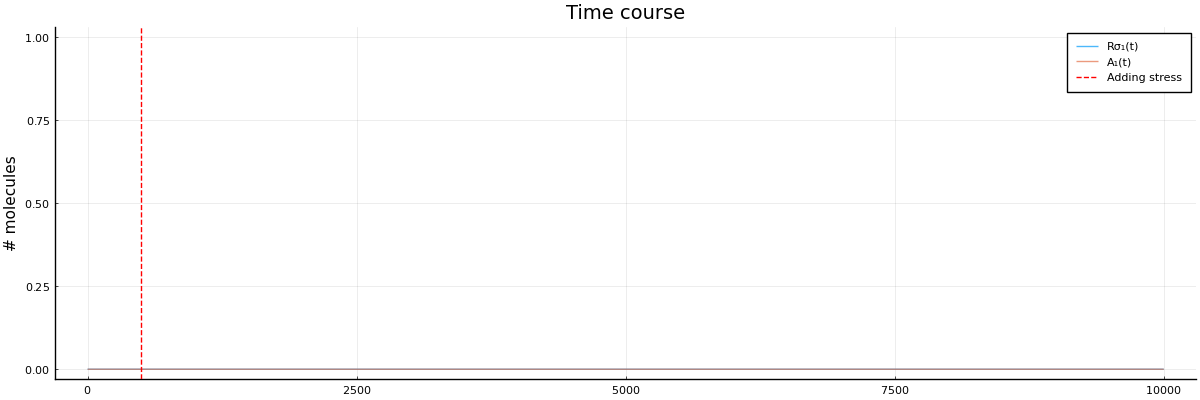

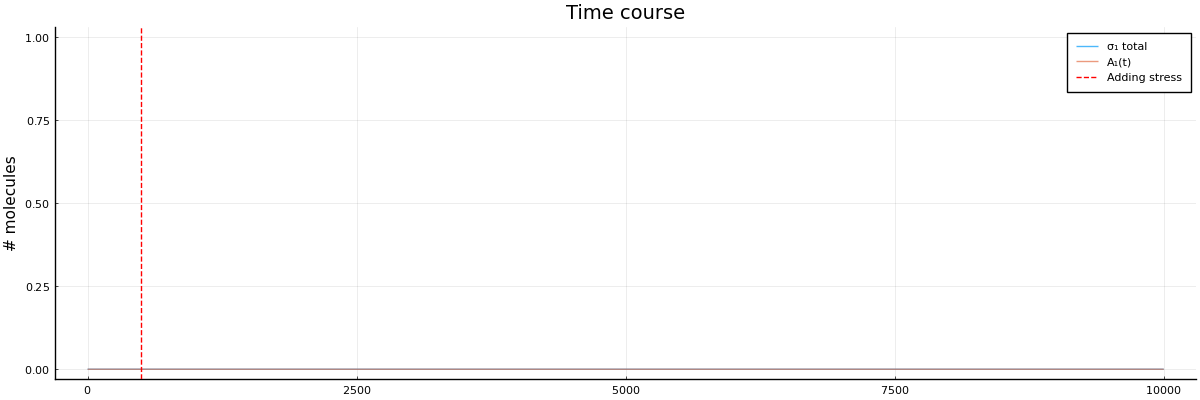

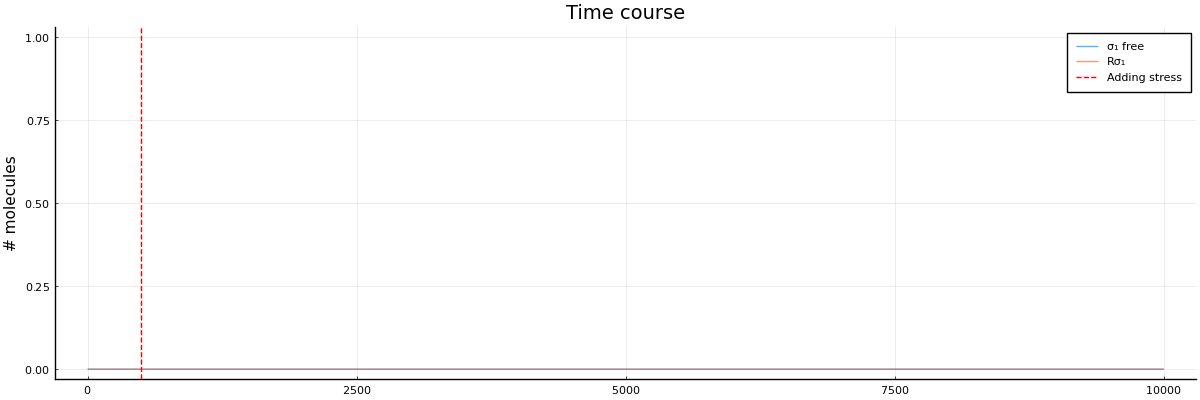

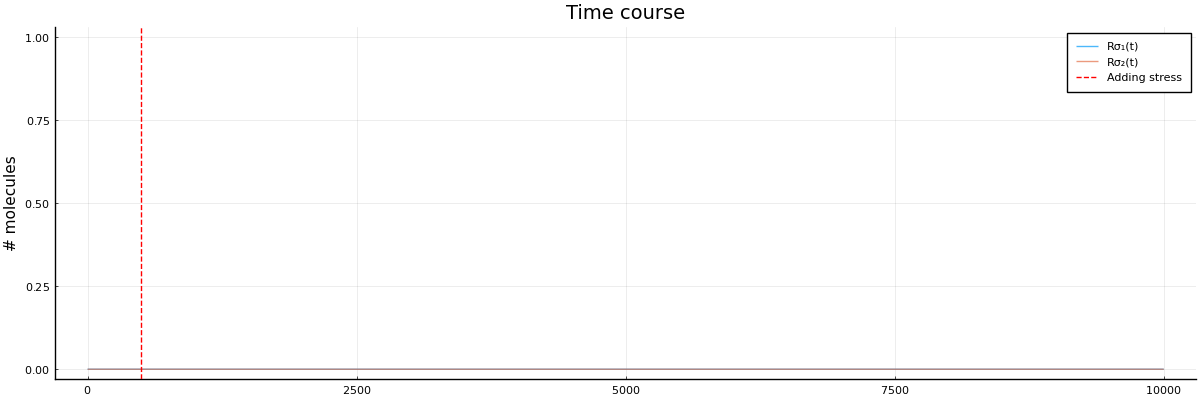

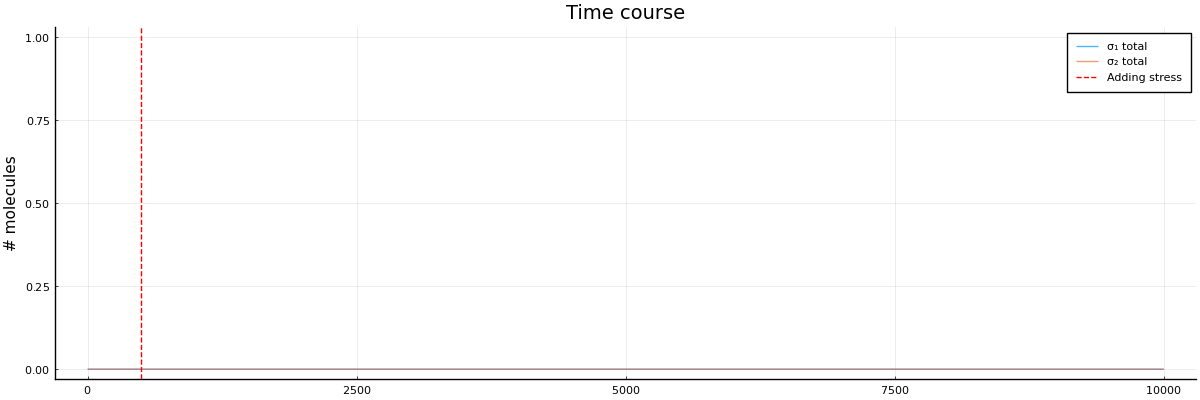

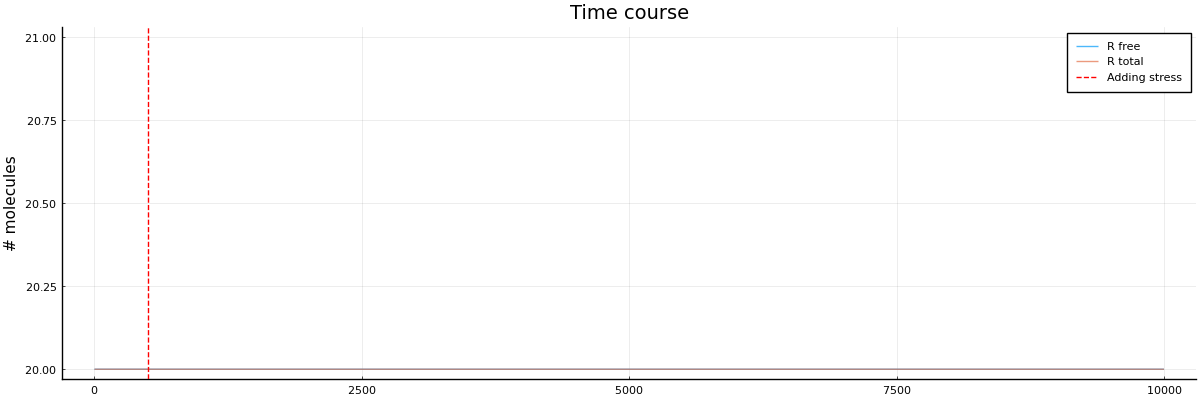

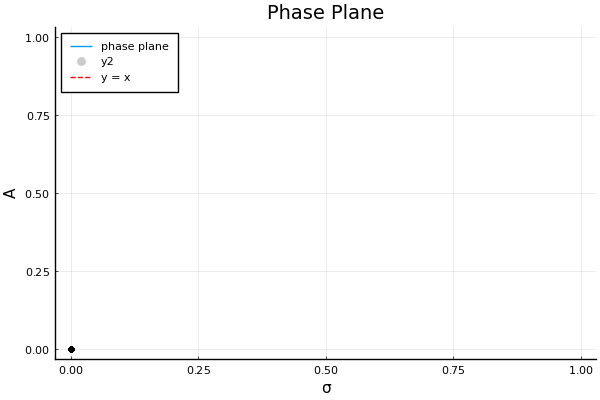

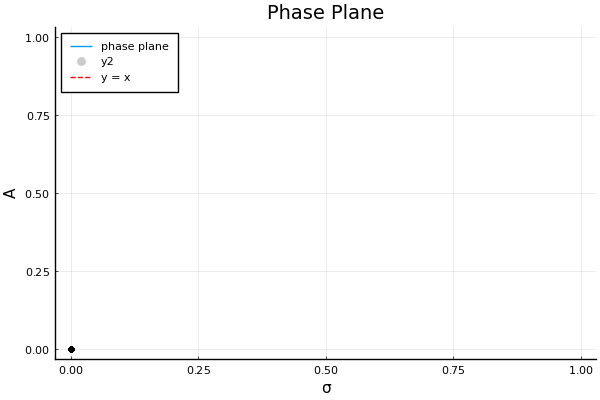


Dominance ratio for 1st Rσ is: 0.0


LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [2]

In [335]:
pyplot()
# settings
max_t = 1e5    # total simulation length
dt = 1.0    # update interval
stress_t = 500.0    # time of stress induction. longer to ensure steady-state
β = 50.0
n = 1.0
τ₁ = 5.0
rτ = 5.0
Rₜ = 20    # total number of RNAP core
k₁ = 5e-4
k₂ = 5e-2

# KS = exp(rand(Uniform(-5.0, 5.0)))
# rK = exp(rand(Uniform(-5.0, 5.0)))
KS = 0.25
rK = 4.0

ts_model = duo_ts_system()
sol = simu_duo_ts_all(ts_model, max_t = max_t,
    _β₁ = β, _β₂ = β, _KS₁ = KS, _rK₁ = rK, _KS₂ = KS, _rK₂ = 1e-6,
    _n₁ = n, _n₂ = n, _τ₁ = τ₁, _rτ = rτ, 
    _Rₜ = Rₜ, _k₁₁ = k₁, _k₂₁ = k₂, _k₁₂ = k₁, _k₂₂ = k₂,
    plot_max_t = 1e4, show_tc = true, show_hill = false, show_pp = true);

# print the dominance ratio
t, Rσ₁, ~ = interpret_sol(select_species(sol, [6, 2]))
~, Rσ₂, ~ = interpret_sol(select_species(sol, [7, 4]))
Rσ₁ = Rσ₁[t .> stress_t]    # mask the pre-stress period
Rσ₂ = Rσ₂[t .> stress_t]
dom1 = sum(Rσ₁ .> Rσ₂) / length(Rσ₁)
# display
println("Dominance ratio for 1st Rσ is: ", dom1)

# for sigma2 see 7, 4
regime = classify_by_timetraj(
    select_species(sol, [6, 2]), stress_t, dt, β, n, 
    thres_v = 0.0015, fluc_f = 2,
    show_vf_plot = true, show_v_heatmap = true, show_p_heatmap = true, quiet = false);
regime = classify_by_timetraj(
    select_species(sol, [7, 4]), stress_t, dt, β, n, 
    thres_v = 0.0015, fluc_f = 2,
    show_vf_plot = true, show_v_heatmap = true, show_p_heatmap = true, quiet = false);

Best bistability so far:

KD₁/KS₁ = 40.0; KS₁ = 7.2KD₂/KS₂ = 4.0; KS₂ = 4.0; τ₂/τ₁ = 5.0; β₁ = 50.0; β₂ = 50.0; n₁ = 1.0; n₂ = 1.0; k₁₁ = 0.0003; k₂₁ = 0.05; k₁₂ = 0.001; k₂₂ = 0.05; Rₜ = 100

## Plot dominance against association rate

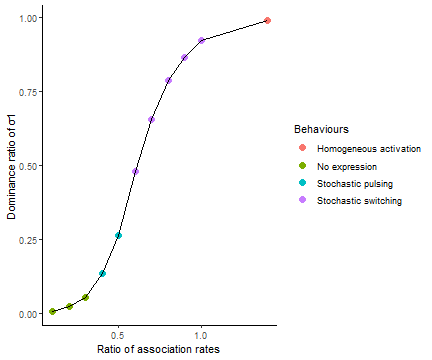

RObject{VecSxp}


In [40]:
using RCall
using DataFrames

@rlibrary ggplot2    # use R library

# ratio between the association rate of σ₁ and σ₂ (to RNAP core)
rka = [range(0.1, 1.0, step = 0.1); 1.4]
# dominance ratio of Rσ₁
dr1 = [6.58e-3, 2.33e-2, 5.23e-2, 0.133, 0.263, 0.479, 0.656,
    0.787, 0.867, 0.924, 0.993]
# behaviour of σ₁ network
behav = getindex.(
    [Dict(1 => "No expression", 2 => "Stochastic pulsing", 
            3 => "Stochastic switching", 4 => "Homogeneous activation")],
    [1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4])
# dataframe
df = DataFrame(:rka => rka, :dr1 => dr1, :Behaviours => behav)

# plot
p = ggplot(df, aes(:rka, :dr1)) +
    geom_point(aes(color = :Behaviours), size = 3) +
    geom_line() +
    labs(x = "Ratio of association rates", y = "Dominance ratio of σ1") +
    theme_classic()

In [41]:
ggsave("dominance_curve.pdf", p, width = 16, height = 8, units = "cm")

RObject{NilSxp}
NULL
